# 4. Application
This sheet can be run
Combines image model features and nlp features to provide recommend furniture

### 1. IMPORTS AND LIBRARIES

In [29]:
import numpy as np
import pandas as pd

from keras.applications import VGG16
import tables
import dill



# Libraries for displying the data. 
from IPython.core.display import HTML 
from ipywidgets import interact
from IPython.display import display
from IPython.display import Image

In [30]:
import itertools
from keras.models import Model
import keras
from keras import models, layers, optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [31]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

In [32]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

### 2. HELPER FUNCTIONS

In [33]:
size = 224
def get_input(img_path):
    img = imread(img_path)
    img = resize(img, (size, size,3), preserve_range=True).astype(np.float32)
    #img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [34]:
def get_predictions(img_path, model,decode=True):
    input_ = get_input(img_path)
    out = model.predict(input_)
    if decode:
        return decode_predictions(out)
    else:
        return out

### 3. LOAD IMAGE RECOMMENDER DATA

In [35]:
df_image = pd.read_csv('../data/model/recommender_matrix.csv') 
df_image = df_image.drop(columns = ['Unnamed: 0'])
print(df_image.shape)
df_image.head(2)

(35965, 132)


,image_link,product_name,page_link,label,ifeature1,ifeature2,ifeature3,ifeature4,ifeature5,ifeature6,...,ifeature119,ifeature120,ifeature121,ifeature122,ifeature123,ifeature124,ifeature125,ifeature126,ifeature127,ifeature128
0,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,0.0,0.0,0.0,0.0,809.76886,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,645.9755
1,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,0.0,0.0,0.0,0.0,606.45230,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513.0549


In [36]:
df_image['label'].value_counts()

coffee table    12543
sofa             9680
tv stand         7033
pouf             3402
armchair         3307
Name: label, dtype: int64

### 4. LOAD IMAGE MODEL 

In [37]:
my_model=models.load_model('../data/model/final_cnn_model.hdf5')

In [38]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [39]:
# I extract features from my second to last layer fc1 which has 128 neurons. 
#This performed better for the recommender  vis-a-vis using fc2 with 64 neurons
# set the following
layer_to_extract = 'fc1'
neurons = 128

In [40]:
my_model_extract = Model(inputs=my_model.input, outputs=my_model.get_layer(layer_to_extract).output)

### 5. LOAD NLP RECOMMENDER DATA

In [76]:
nlp_data = pd.read_csv('../data/model/nlp_matrix.csv')
nlp_data = nlp_data.drop(columns = 'Unnamed: 0')
print(nlp_data.shape)
nlp_data.head(2)

(35965, 11)


,image_link,product_name,page_link,label,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,-0.755367,-1.001257,-5.526652,-5.526095,-1.918496,-5.526696,-5.527224
1,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,-0.755367,-1.001257,-5.526652,-5.526095,-1.918496,-5.526696,-5.527224


In [77]:
# load nlp pipe line

In [78]:
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer

n_gram = 3
stem_type = 'snow' #change this to 'snow' or 'lemma' or 'porter'
snow = SnowballStemmer('english') # change stemmer here
wordnet_lemmatizer = WordNetLemmatizer()
vectorizer = dill.load(open('../data/model/nlp_tf_vectorizer', 'rb'))
lda_model = dill.load(open('../data/model/nlp_lda','rb'))

In [79]:
#text= 'glass metal modern silver steel coffee table'
#text= 'rustic wood wooden distressed pine oak reclaimed coffee table natural'
#text ='leather' 
#text ='leather armchair sofa dark deep contemporary'
#text ='blue sofa linen cloth fabric modern'
#text = 'tv entertainment brown wood console'
#text ='orange bright pouf cube soft square round ottoman cicle'
#text ='Relax with a favorite book in this exquisite accent chair. Featuring birchwood legs and an elegantly pleated exterior, this chair offers superior comfort with high-density foam padding.'
text =""

In [80]:
if(text!="" ):
    user_text = pd.DataFrame(columns=['excerpt'])
    user_text=user_text.append(pd.DataFrame([text], columns=['excerpt']),ignore_index=True)
    #print(user_text)
    vector = vectorizer.transform(user_text['excerpt'])
    #print("----",vector,"----")
    topic_vector = lda_model.transform(vector)
    #print(topic_vector)
    user_excerpt = pd.DataFrame(topic_vector, columns=['topic_'+ str(i)for i in range(1,8)])

In [81]:
user_excerpt

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,-2.639043,-0.560122,-2.639057,-2.639057,-2.635032,-2.639057,-2.639057


In [82]:
user_excerpt=user_excerpt.apply(np.log)
user_excerpt

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6. SIMILARITY FINDER IMAGE

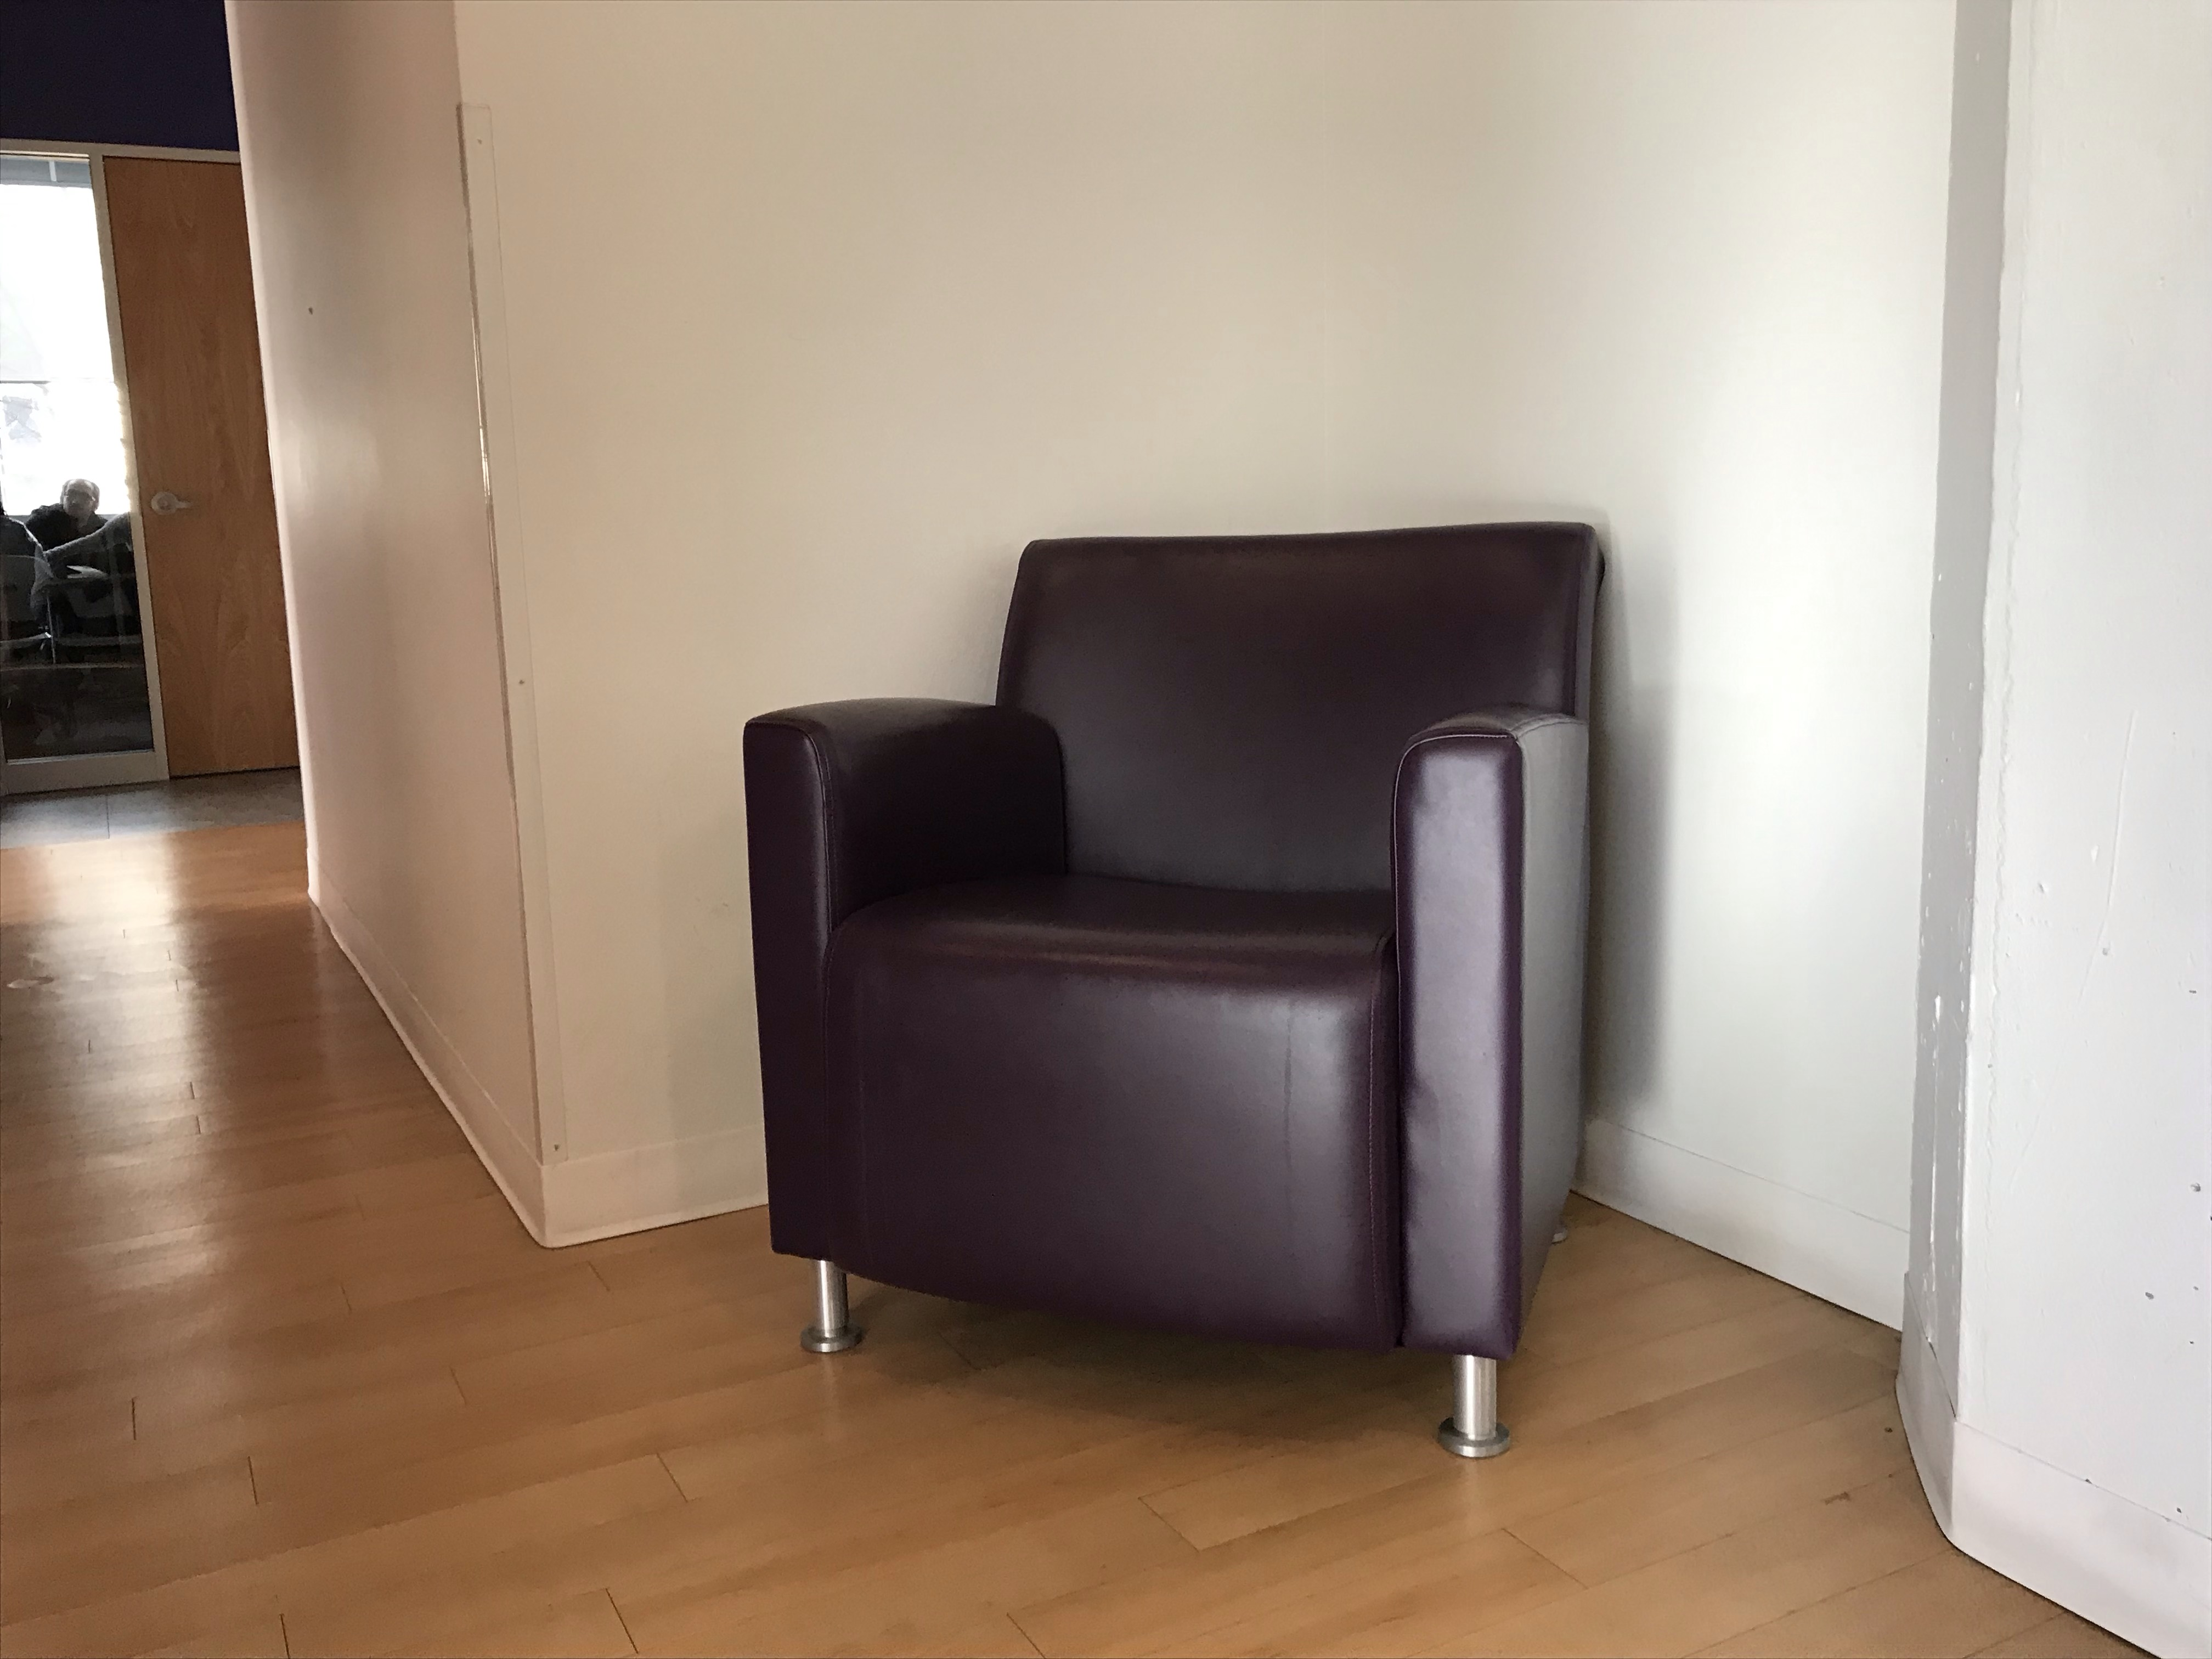

In [83]:
pic_link = '../data/samples/my_pics/IMG_4288.jpg'
display(Image(filename=pic_link,width=300, height=300))

In [84]:
# matrices the input image
user_img_matrix=get_input(pic_link)
user_img_matrix = np.expand_dims(user_img_matrix, axis=0)
user_img_matrix.shape

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1, 224, 224, 3)

In [85]:
user_data = my_model_extract.predict(user_img_matrix)
search_in = np.array(df_image.loc[:,'ifeature1':]) 
print(user_data.shape)
print(search_in.shape)

(1, 128)
(35965, 128)


In [86]:
# similarity metrics

In [87]:
metric = 'euclid'
if(metric == 'euclid'):
    from sklearn.metrics.pairwise import euclidean_distances
    results= euclidean_distances(search_in, user_data)
    show_me_image = pd.DataFrame(results).sort_values(0, ascending=True).head(15)

if(metric == 'cosine'):    
    from sklearn.metrics.pairwise import cosine_similarity
    results = cosine_similarity(search_in, user_data)
    show_me_image = pd.DataFrame(results).sort_values(0, ascending=False).head(15)
    
if(metric == 'manhat'):    
    from sklearn.metrics.pairwise import manhattan_distances
    results = manhattan_distances(search_in, user_data)
    show_me_image = pd.DataFrame(results).sort_values(0, ascending=True).head(15)

show_me_image

,0
29674,388.815957
31499,403.200474
29558,416.651706
30115,424.329219
30288,443.371341
31588,452.125494
31060,463.034576
32234,467.219608
31681,479.836117
32060,506.731185


In [88]:
recommend_image = df_image.iloc[list(show_me_image.index),0:5].values
recommend_image.shape

(15, 5)

In [89]:
# recommendation based only on image similarity

for i in range(0,15):    
    display(Image(url=recommend_image[i][0],width=244, height=244))
    print('Link to page =',  recommend_image[i][2])

Link to page = https://www.overstock.com/Home-Garden/CorLiving-Kelsey-Bonded-Leather-Modern-Recliner-Armchair/12853347/product.html?refccid=XXMJCI7TDDEKEGCG4U4NCDMJ5E&searchidx=57


Link to page = https://www.overstock.com/Home-Garden/Classic-Linen-Armchair-Living-Room-Accent-Chair/17668770/product.html?refccid=O6YEU3LR5EHKNXSPCNT4IBT2GI&searchidx=343


Link to page = https://www.overstock.com/Home-Garden/Abbyson-Montecito-Dark-Brown-Leather-Armchair/5277802/product.html?refccid=XXMJCI7TDDEKEGCG4U4NCDMJ5E&searchidx=35


Link to page = https://www.overstock.com/Home-Garden/Abbyson-Larson-Leather-Armchair/23438177/product.html?refccid=JZBFGYLFJOV2KMSB66Z5BDDNZU&searchidx=137


Link to page = https://www.overstock.com/Home-Garden/Best-Master-Furniture-Faux-Leather-Stainless-Steel-Arm-Accent-Chair/18827974/product.html?refccid=JZBFGYLFJOV2KMSB66Z5BDDNZU&searchidx=161


Link to page = https://www.overstock.com/Home-Garden/DG-Casa-Nelson-Armchair/9985277/product.html?refccid=O6YEU3LR5EHKNXSPCNT4IBT2GI&searchidx=352


Link to page = https://www.overstock.com/Home-Garden/Best-Master-Furniture-C106-Upholstered-Chair/20193363/product.html?refccid=LUB6LASL7RHYCTCJSRSICQW22A&searchidx=273


Link to page = https://www.overstock.com/Home-Garden/Modern-Living-Room-Accent-Arm-Chair-in-Faux-Leather/17793383/product.html?refccid=IMMXQGKOCKUYERCKNXN3RMAC7U&searchidx=499


Link to page = https://www.overstock.com/Home-Garden/Katalina-Chair/20179954/product.html?refccid=5JO5WDPKCAFLDESAWOZ2I4REU4&searchidx=368


Link to page = https://www.overstock.com/Home-Garden/ALEXANDRIA-ARMCHAIR-GIOTTO-GREY-FABRIC/13001004/product.html?refccid=VK4BJ2M5EJYICASCJP5H7Z6HEY&searchidx=459


Link to page = https://www.overstock.com/Home-Garden/Best-Master-Furniture-C106-Upholstered-Chair/20193363/product.html?refccid=LUB6LASL7RHYCTCJSRSICQW22A&searchidx=273


Link to page = https://www.overstock.com/Home-Garden/Modern-Living-Room-Accent-Arm-Chair-in-Faux-Leather/17793383/product.html?refccid=IMMXQGKOCKUYERCKNXN3RMAC7U&searchidx=499


Link to page = https://www.overstock.com/Home-Garden/Aristocrat-Accent-Armchair/19569357/product.html?refccid=VK4BJ2M5EJYICASCJP5H7Z6HEY&searchidx=444


Link to page = https://www.overstock.com/Home-Garden/Modway-Serve-Mid-Century-Polyester-Upholstered-Armchair/12027613/product.html?refccid=MIUS33KSNY52SHKJDXUSTVS7LU&searchidx=231


Link to page = https://www.overstock.com/Home-Garden/Eilidh-Buttoned-Mid-Century-Modern-Tufted-Fabric-Club-Chair-by-Christopher-Knight-Home/17292706/product.html?refccid=XXMJCI7TDDEKEGCG4U4NCDMJ5E&searchidx=17


### 7. FILTER USING NLP SIMILARITY
take the top 15 images that are similar and sort them by text analysis similarity

In [90]:
if(text==""): # no text was given
    recommend_image = df_image.iloc[list(show_me_image.index),0:5].values
else:
    print('# shape em up to numpy arrays')
    given_excerpt = np.array(user_excerpt)
    print(nlp_data.iloc[list(show_me_image.index),4:])
    search_in = np.array(nlp_data.iloc[list(show_me_image.index),4:])
    from sklearn.metrics.pairwise import cosine_similarity
    results2 = cosine_similarity(search_in, given_excerpt)
    show_me_nlp = pd.DataFrame(results2).sort_values(0, ascending=False).head(10)
    print(show_me_nlp)
    final_list = list(show_me_image.iloc[list(show_me_nlp.index),:].index)
    print(final_list)
    recommend_image = df_image.iloc[final_list,0:10].values
    

In [91]:
for i in range(0,10):    
    display(Image(url=recommend_image[i][0],width=244, height=244))
    print('Link to page =',  recommend_image[i][2])

Link to page = https://www.overstock.com/Home-Garden/CorLiving-Kelsey-Bonded-Leather-Modern-Recliner-Armchair/12853347/product.html?refccid=XXMJCI7TDDEKEGCG4U4NCDMJ5E&searchidx=57


Link to page = https://www.overstock.com/Home-Garden/Classic-Linen-Armchair-Living-Room-Accent-Chair/17668770/product.html?refccid=O6YEU3LR5EHKNXSPCNT4IBT2GI&searchidx=343


Link to page = https://www.overstock.com/Home-Garden/Abbyson-Montecito-Dark-Brown-Leather-Armchair/5277802/product.html?refccid=XXMJCI7TDDEKEGCG4U4NCDMJ5E&searchidx=35


Link to page = https://www.overstock.com/Home-Garden/Abbyson-Larson-Leather-Armchair/23438177/product.html?refccid=JZBFGYLFJOV2KMSB66Z5BDDNZU&searchidx=137


Link to page = https://www.overstock.com/Home-Garden/Best-Master-Furniture-Faux-Leather-Stainless-Steel-Arm-Accent-Chair/18827974/product.html?refccid=JZBFGYLFJOV2KMSB66Z5BDDNZU&searchidx=161


Link to page = https://www.overstock.com/Home-Garden/DG-Casa-Nelson-Armchair/9985277/product.html?refccid=O6YEU3LR5EHKNXSPCNT4IBT2GI&searchidx=352


Link to page = https://www.overstock.com/Home-Garden/Best-Master-Furniture-C106-Upholstered-Chair/20193363/product.html?refccid=LUB6LASL7RHYCTCJSRSICQW22A&searchidx=273


Link to page = https://www.overstock.com/Home-Garden/Modern-Living-Room-Accent-Arm-Chair-in-Faux-Leather/17793383/product.html?refccid=IMMXQGKOCKUYERCKNXN3RMAC7U&searchidx=499


Link to page = https://www.overstock.com/Home-Garden/Katalina-Chair/20179954/product.html?refccid=5JO5WDPKCAFLDESAWOZ2I4REU4&searchidx=368


Link to page = https://www.overstock.com/Home-Garden/ALEXANDRIA-ARMCHAIR-GIOTTO-GREY-FABRIC/13001004/product.html?refccid=VK4BJ2M5EJYICASCJP5H7Z6HEY&searchidx=459
